In [1]:
import os
from datetime import datetime
import numpy as np
import glob
from satpy import Scene
import satpy
from typing import List
import subprocess

import cartopy.crs as ccrs
import pandas as pd

import matplotlib.pyplot as plt

import rasterio
from rasterio import Affine as A
from rasterio.warp import reproject, Resampling, calculate_default_transform, transform
from rasterio.control import GroundControlPoint
from rasterio.transform import xy

import xarray as xr
from collections import OrderedDict
from itertools import product

import logging

In [2]:
_LOG = logging.getLogger('reproject')
_LOG.setLevel(logging.DEBUG)

def set_up_logging():
    # Set up logging so logs are visible in Jupyter Lab cells.
    formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')
    stream_handler = logging.StreamHandler()
    stream_handler.setFormatter(formatter)
    _LOG.addHandler(stream_handler)

    # Log to file
    file_handler = logging.FileHandler(
        '/storage/data/eumetsat/native/logs/convert_native_to_reprojected/convert_native_to_reprojected.log',
        mode='a')
    file_handler.setFormatter(formatter)
    file_handler.setLevel(logging.DEBUG)
    _LOG.addHandler(file_handler)


set_up_logging()
_LOG.info('********** START NEW RUN **************')

2020-05-14 13:28:38,889 - INFO - ********** START NEW RUN **************


In [3]:
SAT_IMAGERY_PATH = '/storage/data/eumetsat/native/sorted'
TEMP_PATH = '/home/jack/temp'

In [4]:
def get_directory_for_datetime(sat_imagery_path: str, dt: datetime) -> str:
    """
    Args:
        sat_imagery_path:
        dt: the datetime for the requested image.  Will return
            the directory which is within 5 minutes of the requested image.
    Returns:
        Directory string
        
    Raises:
        FileNotFoundError
    """
    hour_path = dt.strftime("%Y/%m/%d/%H")
    hour_path = os.path.join(SAT_IMAGERY_PATH, hour_path)
    
    # Get a list of subdirectories containing minutes
    try:
        _, minute_dirs, _ = next(os.walk(hour_path))
    except StopIteration:
        raise FileNotFoundError
    minutes_with_images = np.array(minute_dirs, dtype=int)
    
    # Quantize dt.minute to 5-minute intervals
    minute_lower_bound = (dt.minute // 5) * 5
    minute_upper_bound = minute_lower_bound + 5
    
    # Find matching directory for the minutes
    selection_condition = (
        (minute_lower_bound <= minutes_with_images) & 
        (minutes_with_images < minute_upper_bound))
    idx = np.flatnonzero(selection_condition)
    
    # Sanity check
    if idx.size == 0:
        raise FileNotFoundError(2, 'No minute directory for datetime {} under "{}"'.format(dt, hour_path))
    elif idx.size > 1:
        raise RuntimeError(
            'Found > 1 directories with images for datetime {}.'
            '  Base dir = "{}".  Subdirs found = {}'
            .format(dt, hour_path, minute_dirs))
        
    selected_minute_dir = minutes_with_images[idx[0]]
    selected_minute_dir = '{:02d}'.format(selected_minute_dir)
    selected_minute_dir = os.path.join(hour_path, selected_minute_dir)
    
    return selected_minute_dir

In [5]:
def get_image_filename_for_datetime(
    sat_imagery_path: str, 
    dt: datetime,
    pattern: str = 'MSG*.nat.bz2'
    ) -> str:
    
    image_path = get_directory_for_datetime(sat_imagery_path, dt)
    files = glob.glob(os.path.join(image_path, pattern))
    error_str = 'file matching "{}" in "{}" for datetime {}.'.format(pattern, image_path, dt)
    if len(files) == 0:
        raise FileNotFoundError(2, 'No ' + error_str)
    if len(files) > 1:
        _LOG.warning('Found > 1 ' + error_str + '  Expected only one match.')
    image_filename = files[0]
    return image_filename

In [6]:
def decompress(full_bzip_filename: str) -> str:
    base_bzip_filename = os.path.basename(full_bzip_filename)
    base_nat_filename = os.path.splitext(base_bzip_filename)[0]
    full_nat_filename = os.path.join(TEMP_PATH, base_nat_filename)
    if os.path.exists(full_nat_filename):
        os.remove(full_nat_filename)
    with open(full_nat_filename, 'wb') as nat_file_handler:
        process = subprocess.run(
            ['pbzip2', '--decompress', '--keep', '--stdout', full_bzip_filename],
            stdout=nat_file_handler)
    process.check_returncode()
    return full_nat_filename

In [7]:
TYPICAL_EAST_COLUMN_PLANNED = 2733

def get_ground_control_points_for_seviri_hrv(
    src_height: int, 
    src_width: int, 
    east_column_planned: int=TYPICAL_EAST_COLUMN_PLANNED) -> List:
    """
    Args:
        east_column_planned: Taken from the Native file header:
          header['15_DATA_HEADER']['ImageDescription']['PlannedCoverageHRV']['LowerEastColumnPlanned']
          The HRV channel on Meteosat Second Generation satellites doesn't scan the full number of columns.
          The east boundary of the HRV channel changes (e.g. to maximise the amount of the image which
          is illuminated by sunlight.
    """
    x_offset = 1000 + ((TYPICAL_EAST_COLUMN_PLANNED - east_column_planned) * 1000)
    y_offset = 500
    
    # These parameters are taking from the HRIT version of the HRV channel,
    # and then tweaked a bit by eye, to get a better alignment between the image
    # and the coastlines overlay.  For reference, the original 'Area extent' from
    # scene.to_xarray_dataset().attrs is (2799876.1893, 5571248.5489, -2768872.0236, 1394687.3892)
    left =  -2736372.0236 + x_offset
    right =  2832376.1893 + x_offset
    bottom = 1394687.3495 + y_offset # from scene['HRV'].area
    top =    5570248.4773 + y_offset

    top_left = GroundControlPoint(row=0, col=0, x=left, y=top, id='top_left')
    bottom_left = GroundControlPoint(row=src_height, col=0, x=left, y=bottom, id='bottom_left')
    bottom_right = GroundControlPoint(row=src_height, col=src_width, x=right, y=bottom, id='bottom_right')
    top_right = GroundControlPoint(row=0, col=src_width, x=right, y=top, id='top_right')

    ground_control_points = [top_left, bottom_left, bottom_right, top_right]
    return ground_control_points

In [8]:
# Source coordinate reference system
SRC_CRS = {
        'proj': 'geos',  # Geostationary
        'lon_0': 9.5,
        'a': 6378169.0,
        'b': 6356583.8,
        # The EUMETSAT docs say "The distance between spacecraft and centre of earth is 42,164 km. The idealized earth
        # is a perfect ellipsoid with an equator radius of 6378.1690 km and a polar radius of 6356.5838 km." 
        # The projection used by SatPy expresses height as height above the Earth's surface (not distance
        # to the centre of the Earth).
        'h': 35785831.00,  # Height of satellite above the Earth's surface
        'units': 'm'  # meters
}

# Destination coordinate reference system
DST_CRS = {
    'ellps': 'WGS84',
    'proj': 'tmerc',  # Transverse Mercator
    'units': 'm'  # meters
}


def get_east_column_planned(full_nat_filename: str) -> int:
    # HRV images are offset differently on different images, so we need to grab
    # the relevant metadata
    handler = satpy.readers.seviri_l1b_native.NativeMSGFileHandler(full_nat_filename, {}, None)
    planned_coverage_hrv = handler.header['15_DATA_HEADER']['ImageDescription']['PlannedCoverageHRV']
    assert planned_coverage_hrv['LowerSouthLinePlanned'] == 6961
    assert planned_coverage_hrv['LowerNorthLinePlanned'] == 11136
    
    # Check that actual coverage == planned coverage
    actual_coverage_hrv = handler.trailer['15TRAILER']['ImageProductionStats']['ActualL15CoverageHRV']
    keys = [upper_or_lower + compass_heading for upper_or_lower, compass_heading in 
            product(
                ['Lower', 'Upper'], 
                ['SouthLine', 'NorthLine', 'EastColumn', 'WestColumn'])]
    for key in keys:
        actual_key = key + 'Actual'
        actual_value = actual_coverage_hrv[actual_key]
        planned_key = key + 'Planned'
        planned_value = planned_coverage_hrv[planned_key]
        if actual_value != planned_value:
            _LOG.warning('Difference in planned and actual HRV coverage!  {}={} but {}={}'.format(
                actual_key, actual_value, planned_key, planned_value))
    
    return planned_coverage_hrv['LowerEastColumnPlanned']
    

def get_raw_hrv_image(full_nat_filename: str) -> np.ndarray:
    scene = Scene(
        filenames=[full_nat_filename],
        reader='seviri_l1b_native')
    scene.load(['HRV'])
    return scene['HRV'].values


def reproject_hrv(raw_hrv_image: np.ndarray, east_column_planned: int):
    """
    Returns:
      dict with keys: 
        image: 2D np.ndarray
        xs: 1D np.ndarray (x location of each pixel in DST_CRS)
        ys: 1D np.ndarray (y location of each pixel in DST_CRS)
    """
    hrv_height, hrv_width = raw_hrv_image.shape
    ground_control_points = get_ground_control_points_for_seviri_hrv(
        hrv_height, hrv_width, east_column_planned)
    
    # Hard-code destination transform (calculate_default_transform creates 
    # subtly different transforms when the HRV image changes location due to changes
    # in LowerEastColumnPlanned.  We want a constant transform, so we can align the
    # images across time.)
    METERS_PER_PIXEL = 1000
    west, south, east, north = (-3090000, 1690000, 4390000, 9014000)
    dst_width = int((east - west) / METERS_PER_PIXEL)
    dst_height = int((north - south) / METERS_PER_PIXEL)
    dst_transform = rasterio.transform.from_bounds(
        west=west, south=south, east=east, north=north, width=dst_width, height=dst_height)
    
    # Make array of NaNs to accept transformed image
    dst_shape = (dst_height, dst_width)
    dst_array = np.empty(dst_shape, dtype=np.float32)
    dst_array[:, :] = np.nan
    
    # Reproject!
    reproject(
        raw_hrv_image,
        dst_array,
        src_crs=SRC_CRS,
        dst_crs=DST_CRS,
        gcps=ground_control_points,
        dst_transform=dst_transform,
        num_threads=8,
        resampling=Resampling.cubic,
        src_nodata=np.nan)
    
    # Get X's and Y's (coordinates of each column and row, respectively)
    n = max(dst_height, dst_width)
    xs, ys = xy(
        transform=dst_transform,
        rows=np.arange(n),
        cols=np.arange(n))
    ys = ys[:dst_height]
    xs = xs[:dst_width]
    
    # The Xs and Ys are integers represented as floats even though they
    # are integer values, so convert to ints.
    ys = np.int64(ys)
    xs = np.int64(xs)
    
    return {
        'image': dst_array,
        'xs': xs,
        'ys': ys}


def get_data_array(
    dt: datetime, 
    image: np.ndarray, 
    xs: np.ndarray, 
    ys: np.ndarray) -> xr.DataArray:
    
    dims = OrderedDict()
    dims['time'] = [dt]
    dims['y'] = ys
    dims['x'] = xs

    shape = [len(values) for values in dims.values()]
    data = np.empty(shape, dtype=np.float32)
    data[:, :, :] = np.nan

    data_array = xr.DataArray(
        image.reshape((1, ) + image.shape),
        coords=dims,
        dims=dims.keys(),
        name='HRV')
    
    # Crop off top and bottom of image, which contains no data:
    Y_LIM_TRANSVERSE_MERCATOR = (9014000, 1690000)
    data_array = data_array.sel(y=slice(*Y_LIM_TRANSVERSE_MERCATOR))
    return data_array

    
def get_reprojected_image(sat_imagery_path: str, dt: datetime) -> xr.DataArray:
    full_bzip_filename = get_image_filename_for_datetime(sat_imagery_path, dt)
    full_nat_filename = decompress(full_bzip_filename)
    raw_hrv_image = get_raw_hrv_image(full_nat_filename)
    east_column_planned = get_east_column_planned(full_nat_filename)
    os.remove(full_nat_filename)
    
    reprojected = reproject_hrv(raw_hrv_image, east_column_planned)
    data_array = get_data_array(dt=dt, **reprojected)
    data_array.attrs.update({
        #'crs': DST_CRS,  # TODO: How to save this to a netcdf file?
        'LowerEastColumnPlanned': east_column_planned,
        'full_bzip_filename': full_bzip_filename,
        'full_nat_filename': full_nat_filename})
    
    return data_array

In [9]:
%%time

dt = datetime(year=2018, month=7, day=1, hour=4, minute=15)
da = get_reprojected_image(SAT_IMAGERY_PATH, dt)

2020-05-14 13:28:39,111 - WARNING - Found > 1 file matching "MSG*.nat.bz2" in "/storage/data/eumetsat/native/sorted/2018/07/01/04/19" for datetime 2018-07-01 04:15:00.  Expected only one match.
/home/jack/miniconda3/envs/sat_image_processing/lib/python3.7/site-packages/pyproj/crs/crs.py:543: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj_string = self.to_proj4()
2020-05-14 13:28:39,978 - WARNING - Difference in planned and actual HRV coverage!  LowerNorthLineActual=9860 but LowerNorthLinePlanned=11136


CPU times: user 13.7 s, sys: 450 ms, total: 14.1 s
Wall time: 4.1 s


In [10]:
# Try plotting some geographical points from lat/lon coordinates.

lat_lons = pd.DataFrame(
    {'london': {'lat': 51.5074, 'lon': 0.1278}}).T

reprojected_x, reprojected_y = transform(
    src_crs={'init': 'EPSG:4326'},
    dst_crs=DST_CRS,
    xs=lat_lons['lon'],
    ys=lat_lons['lat'])

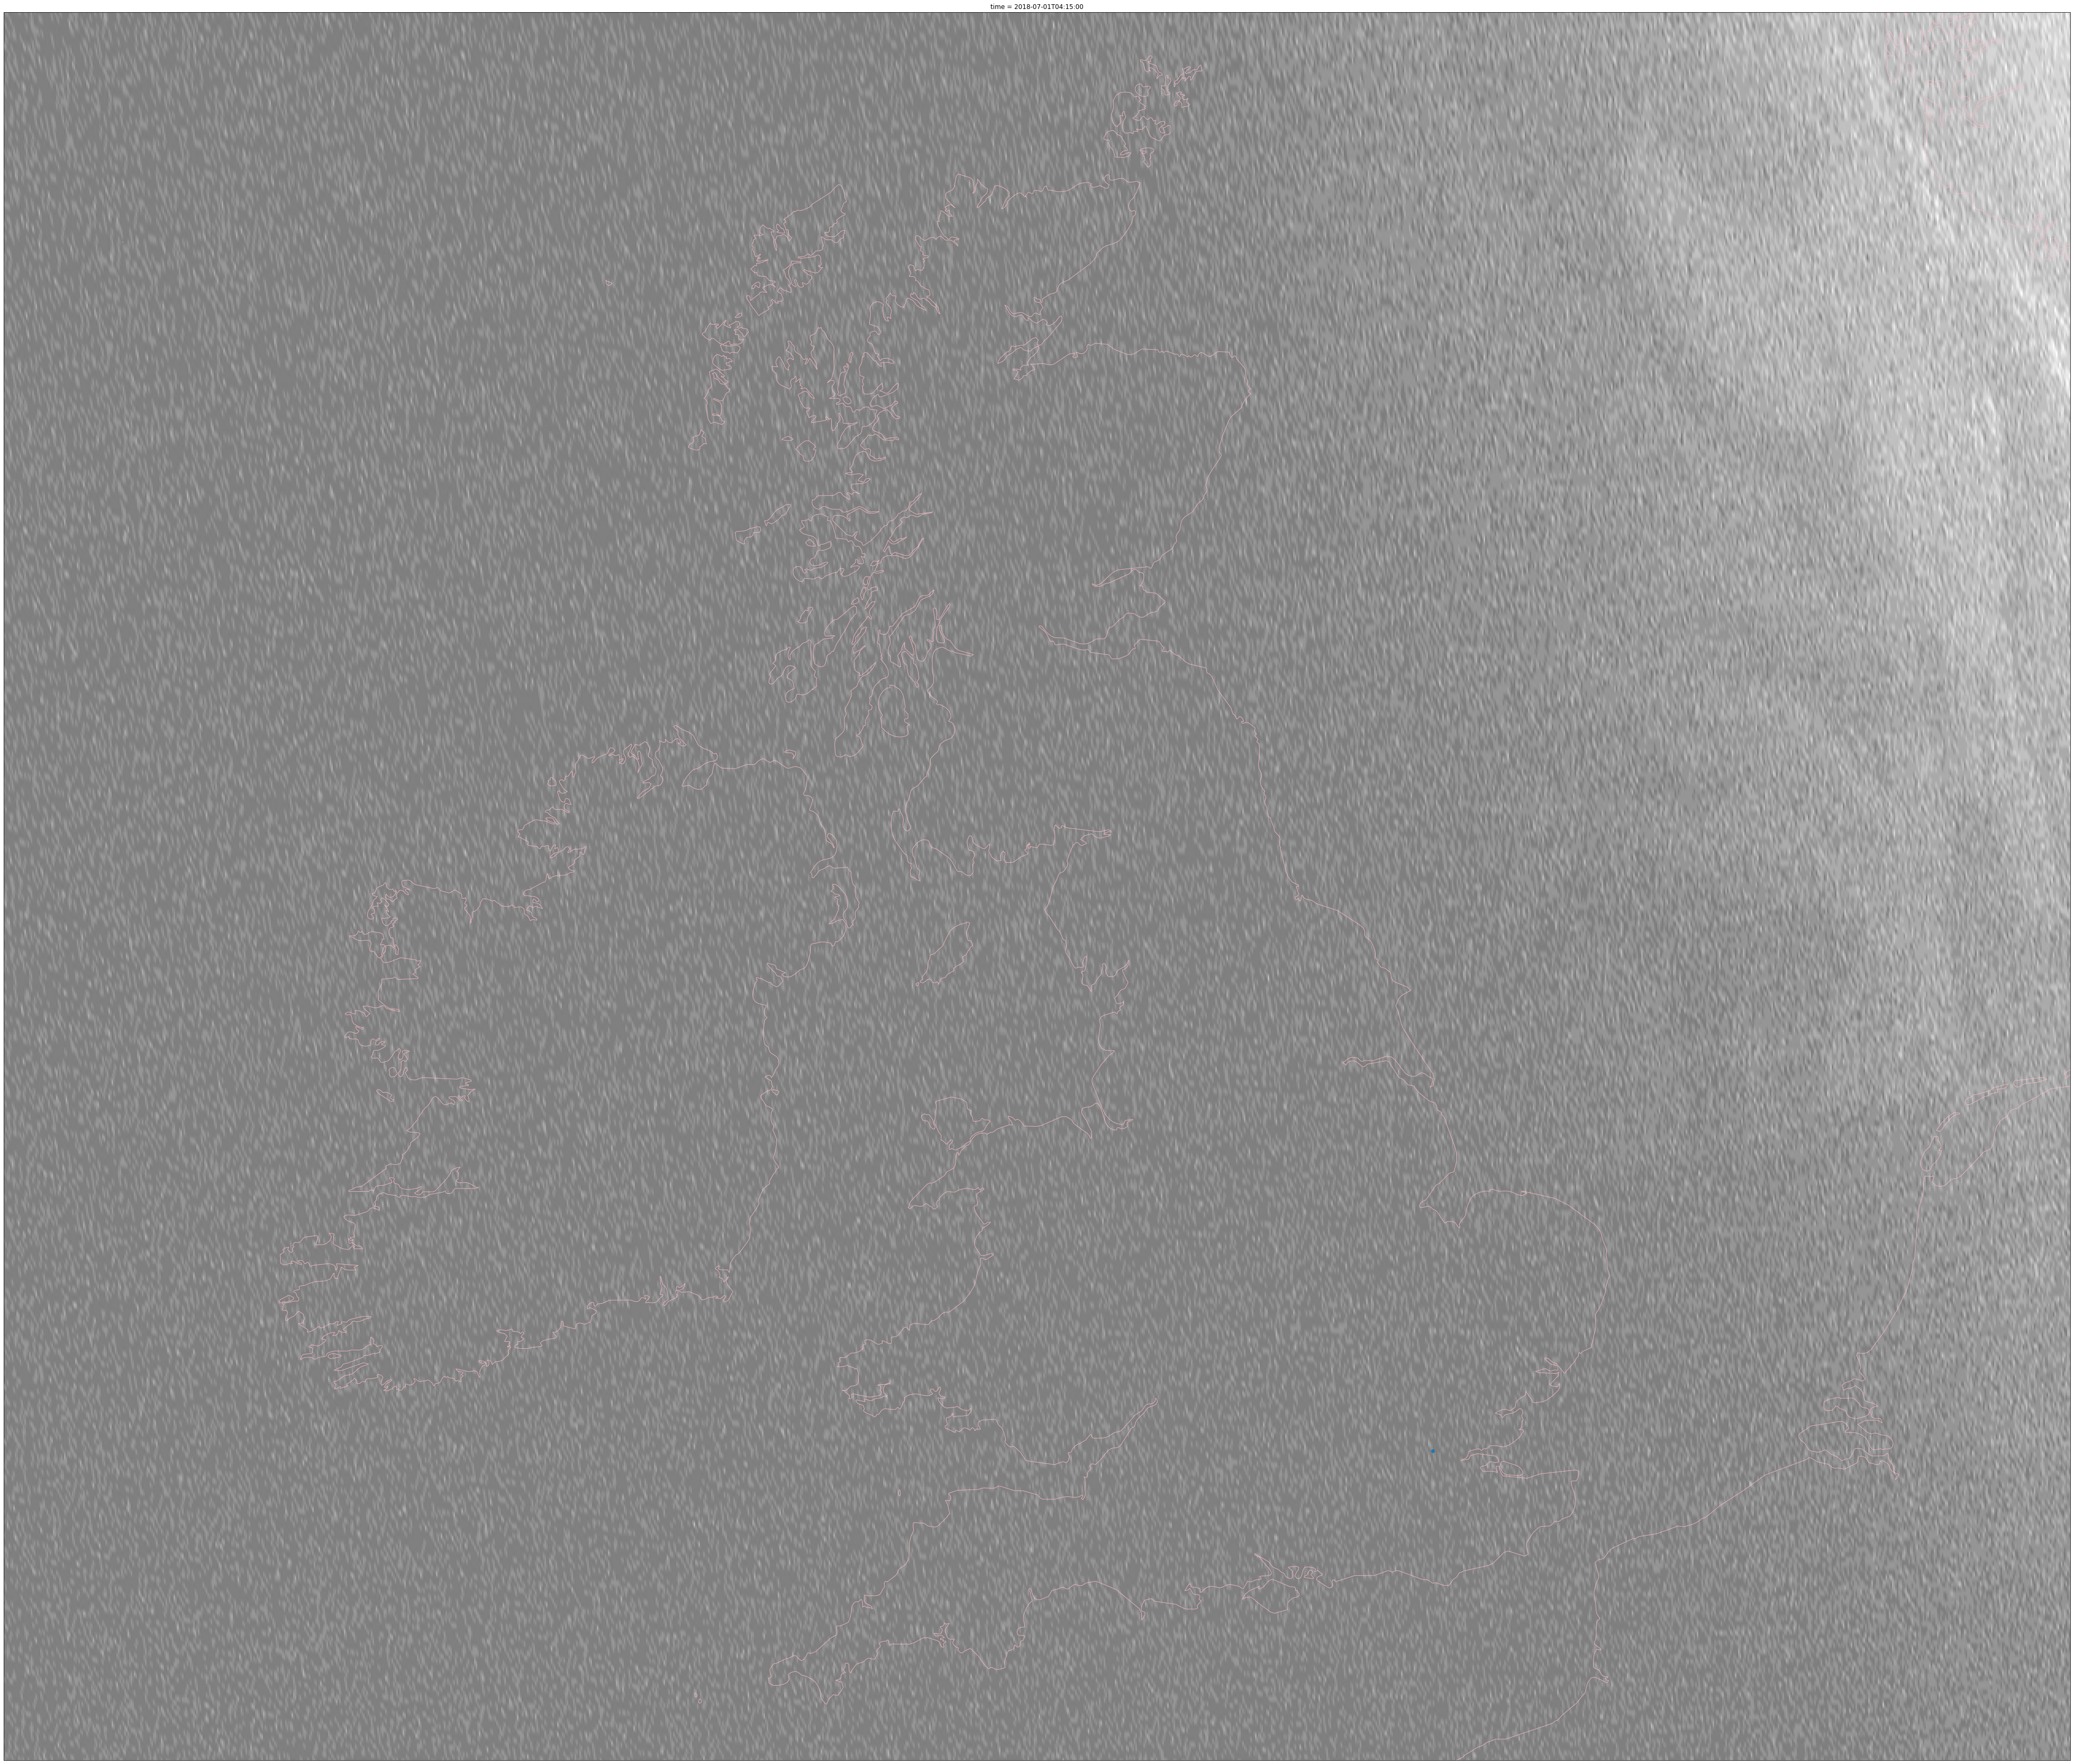

In [11]:
fig = plt.figure(figsize=(70, 70))
ax = plt.axes(projection=ccrs.TransverseMercator())
ax.coastlines(resolution='10m', alpha=0.8, color='pink')
ax.scatter(reprojected_x, reprojected_y)
da[0, 2400:3500, 2200:3500].plot.imshow(ax=ax, cmap='gray', add_colorbar=False);

In [12]:
%%time
DATE_RANGE = []
for start, end in (
        ('2018-07-01 02:00', '2018-07-31 21:00'),
        ('2018-09-01 02:00', '2018-12-31 21:00')):
    DATE_RANGE.extend(pd.date_range(start, end, freq='5T'))

CPU times: user 85.5 ms, sys: 12.1 ms, total: 97.6 ms
Wall time: 97.7 ms


In [13]:
# Compression (adapted from https://stackoverflow.com/a/40818232)
# Mostly turn off compression - it takes too long!
ENABLE_COMPRESSION = False
if ENABLE_COMPRESSION:
    encoding = {'HRV': {'zlib': True, 'complevel': 5}}
else:
    encoding = None

data_arrays = []
for i, dt in enumerate(DATE_RANGE):
    _LOG.info('loading {}'.format(dt))
    try:
        data_array = get_reprojected_image(SAT_IMAGERY_PATH, dt)
    except FileNotFoundError:
        _LOG.warning('No file found for {}'.format(dt))
    else:
        data_arrays.append(data_array)
    
    if data_arrays and (i == len(DATE_RANGE) - 1 or DATE_RANGE[i+1].hour != dt.hour):
        concatenated = xr.concat(data_arrays, dim='time')
        filename = os.path.join('/storage/data/eumetsat/native/reprojected2', '{}.nc'.format(dt.strftime('%Y-%m-%dT%H')))
        _LOG.info('Saving {}'.format(filename))
        concatenated.to_netcdf(
            path=filename,
            engine='netcdf4',
            encoding=encoding)
        data_arrays = []

2020-05-14 13:28:45,723 - INFO - loading 2018-07-01 02:00:00
2020-05-14 13:28:45,725 - WARNING - No file found for 2018-07-01 02:00:00
2020-05-14 13:28:45,725 - INFO - loading 2018-07-01 02:05:00
2020-05-14 13:28:45,726 - WARNING - No file found for 2018-07-01 02:05:00
2020-05-14 13:28:45,727 - INFO - loading 2018-07-01 02:10:00
2020-05-14 13:28:45,727 - WARNING - No file found for 2018-07-01 02:10:00
2020-05-14 13:28:45,728 - INFO - loading 2018-07-01 02:15:00
2020-05-14 13:28:45,728 - WARNING - No file found for 2018-07-01 02:15:00
2020-05-14 13:28:45,728 - INFO - loading 2018-07-01 02:20:00
2020-05-14 13:28:45,729 - WARNING - No file found for 2018-07-01 02:20:00
2020-05-14 13:28:45,729 - INFO - loading 2018-07-01 02:25:00
2020-05-14 13:28:45,730 - WARNING - No file found for 2018-07-01 02:25:00
2020-05-14 13:28:45,730 - INFO - loading 2018-07-01 02:30:00
2020-05-14 13:28:45,731 - WARNING - No file found for 2018-07-01 02:30:00
2020-05-14 13:28:45,731 - INFO - loading 2018-07-01 02:

KeyboardInterrupt: 

In [ ]:
fig = plt.figure(figsize=(70, 70))
ax = plt.axes(projection=ccrs.TransverseMercator())
ax.coastlines(resolution='50m', alpha=0.2)
ax.scatter(reprojected_x, reprojected_y)
concatenated.isel(time=0).plot.imshow(ax=ax, cmap='gray');